# Step 1. Getting the SEED dataset

## 1.1 load the matlab format files and take a look

In [1]:
%load_ext memory_profiler

In [2]:
%memit

peak memory: 90.30 MiB, increment: 0.13 MiB


In [3]:
import mne
from scipy import io
import os
import numpy as np

In [4]:
folderpath = "./Preprocessed_EEG"

In [5]:
raw_eeg = []
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/1_20131027.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/1_20131030.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/1_20131107.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/2_20140404.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/2_20140413.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/2_20140419.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/3_20140603.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/3_20140611.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/3_20140629.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/4_20140621.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/4_20140702.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/4_20140705.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/5_20140411.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/5_20140418.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/5_20140506.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/6_20130712.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/6_20131016.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/6_20131113.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/7_20131027.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/7_20131030.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/7_20131106.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/8_20140511.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/8_20140514.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/8_20140521.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/9_20140620.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/9_20140627.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/9_20140704.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/10_20131130.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/10_20131204.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/10_20131211.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/11_20140618.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/11_20140625.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/11_20140630.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/12_20131127.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/12_20131201.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/12_20131207.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/13_20140527.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/13_20140603.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/13_20140610.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/14_20140601.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/14_20140615.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/14_20140627.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/15_20130709.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/15_20131016.mat'))
%memit raw_eeg.append(io.loadmat('./Preprocessed_EEG/15_20131105.mat'))

peak memory: 521.09 MiB, increment: 328.91 MiB
peak memory: 848.60 MiB, increment: 327.49 MiB
peak memory: 1173.78 MiB, increment: 325.07 MiB
peak memory: 1496.71 MiB, increment: 322.93 MiB
peak memory: 1820.80 MiB, increment: 324.09 MiB
peak memory: 2142.70 MiB, increment: 321.90 MiB
peak memory: 2464.36 MiB, increment: 321.62 MiB
peak memory: 2785.41 MiB, increment: 321.04 MiB
peak memory: 3106.59 MiB, increment: 321.08 MiB
peak memory: 3427.80 MiB, increment: 321.14 MiB
peak memory: 3748.96 MiB, increment: 321.14 MiB
peak memory: 4070.77 MiB, increment: 321.81 MiB
peak memory: 4392.56 MiB, increment: 321.79 MiB
peak memory: 4713.99 MiB, increment: 321.38 MiB
peak memory: 5035.14 MiB, increment: 321.15 MiB
peak memory: 5356.19 MiB, increment: 321.04 MiB
peak memory: 5679.13 MiB, increment: 322.85 MiB
peak memory: 6003.65 MiB, increment: 324.52 MiB
peak memory: 6327.34 MiB, increment: 323.62 MiB
peak memory: 6648.52 MiB, increment: 321.18 MiB
peak memory: 6970.86 MiB, increment: 322.3

In [7]:
len(raw_eeg)

45

In [6]:
for i in range(15):
    print(raw_eeg[3 * i].keys())

dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15'])
dict_keys(['__header__', '__version__', '__globals__', 'jl_eeg1', 'jl_eeg2', 'jl_eeg3', 'jl_eeg4', 'jl_eeg5', 'jl_eeg6', 'jl_eeg7', 'jl_eeg8', 'jl_eeg9', 'jl_eeg10', 'jl_eeg11', 'jl_eeg12', 'jl_eeg13', 'jl_eeg14', 'jl_eeg15'])
dict_keys(['__header__', '__version__', '__globals__', 'jj_eeg1', 'jj_eeg2', 'jj_eeg3', 'jj_eeg4', 'jj_eeg5', 'jj_eeg6', 'jj_eeg7', 'jj_eeg8', 'jj_eeg9', 'jj_eeg10', 'jj_eeg11', 'jj_eeg12', 'jj_eeg13', 'jj_eeg14', 'jj_eeg15'])
dict_keys(['__header__', '__version__', '__globals__', 'lqj_eeg1', 'lqj_eeg2', 'lqj_eeg3', 'lqj_eeg4', 'lqj_eeg5', 'lqj_eeg6', 'lqj_eeg7', 'lqj_eeg8', 'lqj_eeg9', 'lqj_eeg10', 'lqj_eeg11', 'lqj_eeg12', 'lqj_eeg13', 'lqj_eeg14', 'lqj_eeg15'])
dict_keys(['__header__', '__version__', '__globals__', 'ly_eeg

In [8]:
raw_eeg[0]['djc_eeg1'].shape, raw_eeg[4]['jl_eeg1'].shape

((62, 47001), (62, 47001))

raw_1_1['djc_eeg1']:
- raw_1_1: the raw eeg data, the 1st subject(out of 15 subjects), the 1st experiments(out of 3 experiments)
- 'djc_eeg1': djc could possibly mean the name of the subject(which leaks the privacy XD), and 'eeg1' represents it is the 1st trial(out of 15 trials)
- 62: n_channels
- 47001: roughly 4 mins(240sec * 200 Hz sampling rate) the eeg signal during watching the movies

In [9]:
label = io.loadmat('./Preprocessed_EEG/label.mat')

In [10]:
label['label'][0]

array([ 1,  0, -1, -1,  0,  1, -1,  0,  1,  1,  0, -1,  0,  1, -1],
      dtype=int16)

## 1.2 Create the torch dataset

### 1.2.1 cut compute windows

since a movie clip contains eeg signals of ~240 seconds with sf=200Hz, I decide to cut them into 4 sec windows

In [11]:
len_window = 200 * 4

raw_X = []
raw_y = []

prefix = ['djc', 'jl', 'jj', 'lqj', 'ly', 'mhw', 'phl', 'sxy', 'wk', 'ww', 'wsf', 'wyw', 'xyl', 'ys', 'zjy']
sub = 0

while raw_eeg and sub < 12: # only using the first 12 subjects to avoid memory exceed
    # exp 1
    element = raw_eeg.pop(0)
    for i in range(1, 16):
        data = element[prefix[sub] + "_eeg" + str(i)]
        # print(data.shape)
        n_windows = data.shape[1] // len_window
        # print(n_windows)
        reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
        raw_X.append(reshaped_X)
        raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))
    del element


    # exp 2 
    element = raw_eeg.pop(0)
    for i in range(1, 16):
        data = element[prefix[sub] + "_eeg" + str(i)]
        # print(data.shape)
        n_windows = data.shape[1] // len_window
        # print(n_windows)
        reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
        raw_X.append(reshaped_X)
        raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))
    del element

    # exp 1
    element = raw_eeg.pop(0)
    for i in range(1, 16):
        data = element[prefix[sub] + "_eeg" + str(i)]
        # print(data.shape)
        n_windows = data.shape[1] // len_window
        # print(n_windows)
        reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
        raw_X.append(reshaped_X)
        raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))
    del element

    sub += 1

In [12]:
%memit concat_X = np.concatenate(raw_X, axis=2)
print(concat_X.shape)
concat_y = np.concatenate(raw_y)
print(concat_y.shape)

%memit del raw_X, raw_y

peak memory: 26155.39 MiB, increment: 11470.61 MiB
(62, 800, 30312)
(30312,)
peak memory: 26155.40 MiB, increment: 0.00 MiB


### 1.2.2 Encode the labels

In [13]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [14]:
concat_y

array([ 1,  1,  1, ..., -1, -1, -1], dtype=int16)

In [15]:
le = LabelEncoder()
y = le.fit_transform(concat_y)
y = pd.get_dummies(y)
y

,0,1,2
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
30307,1,0,0
30308,1,0,0
30309,1,0,0
30310,1,0,0


one-hot encoding
- positive:  1 => [0, 0 ,1]
- neutral:   0 => [0, 1, 0]
- negative: -1 => [1, 0, 0]

In [16]:
y.shape, concat_X.shape

((30312, 3), (62, 800, 30312))

# Step 2. Create EEG-conformer model

In [17]:
import torch
# from braindecode.models import EEGConformer
from braindecode.util import set_random_seeds

from eegconformer import EEGConformer

/home/pai/envs/fbc/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
cuda = torch.cuda.is_available()
print(cuda)
device = "cuda" if cuda else "cpu"
device

True


'cuda'

In [19]:
cuda_version = torch.version.cuda
cuda_version

'11.7'

In [20]:
seed = 20240216
set_random_seeds(seed=seed, cuda=cuda)

model = EEGConformer(
    n_outputs=3,
    n_chans=62,
    n_times=800, # input_winodw_samples
    input_window_seconds=4,
    sfreq=200,
)

print(model)

/mnt/workspace/BCI-emotion-recognition/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGConformer (EEGConformer)                                  [1, 62, 800]              [1, 3]                    --                        --
├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 62, 800]           [1, 47, 40]               --                        --
│    └─Sequential (shallownet): 2-1                          [1, 1, 62, 800]           [1, 40, 1, 47]            --                        --
│    │    └─Conv2d (0): 3-1                                  [1, 1, 62, 800]           [1, 40, 62, 776]          1,040                     [1, 25]
│    │    └─Conv2d (1): 3-2                                  [1, 40, 62, 776]          [1, 40, 1, 776]           99,240                    [62, 1]
│    │    └─BatchNorm2d (2): 3-3                             [1, 40, 1, 776]           [1, 40, 1, 776]           80             

In [21]:
if cuda:
    model.cuda()

# Step 3. Training the model

## 3.1 prepare the train set / test set

In [22]:
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib_inline

In [23]:
concat_X.shape, y.shape

((62, 800, 30312), (30312, 3))

In [24]:
%memit X = concat_X.transpose((2, 0, 1))
X.shape

del concat_X

peak memory: 17295.00 MiB, increment: 0.04 MiB


In [25]:
%memit X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=777)


peak memory: 28653.89 MiB, increment: 11358.80 MiB


In [26]:
del X

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21218, 62, 800), (9094, 62, 800), (21218, 3), (9094, 3))

## 3.2 Training

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

x_train_tensor = torch.from_numpy(X_train).to(torch.float32).to(device)
y_train_tensor = torch.from_numpy(y_train.values).to(torch.float32).to(device)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

x_test_tensor = torch.from_numpy(X_test).to(torch.float32).to(device)
y_test_tensor = torch.from_numpy(y_test.values).to(torch.float32).to(device)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

In [30]:
def train(model, x_train, y_train, x_test, y_test, save_path='./model_transformer/', n_epochs=100):
    """
    the training function.
    Attributes:
    - model: the instance of the network
    - save_path: the path to which the model state will be saved. None means w/o saving.

    Return: 
    the best model if save_path is not None, the last model otherwise
    """
    train_acc_list.clear()
    train_loss_list.clear()
    test_acc_list.clear()
    test_loss_list.clear()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('the model will be trained on: ', device)

    best_accuracy = 0.0
    
    for epoch in range(n_epochs):
        training_loss = 0.0
        testing_loss = 0.0
        correct = 0
        total = 0
        
        model.train()
        for inputs, labels in tqdm(train_loader):
            # print(inputs.shape, labels.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print("lables.size", labels.shape)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            # print(outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, label = torch.max(labels, 1)
            # print(predicted.shape)
            total += labels.size(0)
            correct += (predicted == label).sum().item()
        
        train_loss = training_loss / len(train_loader)
        train_loss_list.append(train_loss)
        train_accuracy = correct / total
        train_acc_list.append(train_accuracy)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                testing_loss += loss.item()


                _, predicted = torch.max(outputs.data, 1)
                _, label = torch.max(labels, 1)
                total += labels.size(0)
                correct += (predicted == label).sum().item()
            
            test_loss = testing_loss / len(test_loader)
            test_loss_list.append(test_loss)
            test_accuracy = correct / total
            test_acc_list.append(test_accuracy)

            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                if save_path is not None:
                    torch.save(model.state_dict(), save_path + 'best_model.pth')
                    print("best_model found, best acc: ", best_accuracy)
        
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")
    
    if save_path is not None: 
        model.load_state_dict(torch.load(save_path + 'best_model.pth'))
    
    return model

In [31]:
best_model = train(model, X_train, X_test, y_train, y_test, n_epochs=20)

the model will be trained on:  cuda


100%|██████████| 664/664 [00:21<00:00, 30.63it/s]


best_model found, best acc:  0.6094127996481197
Epoch 1/20 - Train Loss: 0.9728 - Train Accuracy: 0.5048 - Test Loss: 0.8668 - Test Accuracy: 0.6094


100%|██████████| 664/664 [00:21<00:00, 31.52it/s]


best_model found, best acc:  0.9661315152848031
Epoch 2/20 - Train Loss: 0.4197 - Train Accuracy: 0.8366 - Test Loss: 0.0921 - Test Accuracy: 0.9661


100%|██████████| 664/664 [00:21<00:00, 31.43it/s]


best_model found, best acc:  0.9861447107983285
Epoch 3/20 - Train Loss: 0.1832 - Train Accuracy: 0.9370 - Test Loss: 0.0363 - Test Accuracy: 0.9861


100%|██████████| 664/664 [00:20<00:00, 31.87it/s]


best_model found, best acc:  0.9960413459423796
Epoch 4/20 - Train Loss: 0.1181 - Train Accuracy: 0.9599 - Test Loss: 0.0151 - Test Accuracy: 0.9960


100%|██████████| 664/664 [00:20<00:00, 31.74it/s]


best_model found, best acc:  0.9970310094567847
Epoch 5/20 - Train Loss: 0.0800 - Train Accuracy: 0.9729 - Test Loss: 0.0115 - Test Accuracy: 0.9970


100%|██████████| 664/664 [00:21<00:00, 31.61it/s]


best_model found, best acc:  0.9994501869364416
Epoch 6/20 - Train Loss: 0.0773 - Train Accuracy: 0.9751 - Test Loss: 0.0056 - Test Accuracy: 0.9995


100%|██████████| 664/664 [00:20<00:00, 31.68it/s]


best_model found, best acc:  0.9997800747745766
Epoch 7/20 - Train Loss: 0.0714 - Train Accuracy: 0.9761 - Test Loss: 0.0029 - Test Accuracy: 0.9998


100%|██████████| 664/664 [00:21<00:00, 31.56it/s]


Epoch 8/20 - Train Loss: 0.0541 - Train Accuracy: 0.9825 - Test Loss: 0.0086 - Test Accuracy: 0.9960


100%|██████████| 664/664 [00:20<00:00, 31.81it/s]


Epoch 9/20 - Train Loss: 0.0522 - Train Accuracy: 0.9833 - Test Loss: 0.0103 - Test Accuracy: 0.9955


100%|██████████| 664/664 [00:20<00:00, 31.63it/s]


Epoch 10/20 - Train Loss: 0.0552 - Train Accuracy: 0.9830 - Test Loss: 0.0030 - Test Accuracy: 0.9993


100%|██████████| 664/664 [00:20<00:00, 31.64it/s]


Epoch 11/20 - Train Loss: 0.0453 - Train Accuracy: 0.9850 - Test Loss: 0.0039 - Test Accuracy: 0.9995


100%|██████████| 664/664 [00:20<00:00, 31.70it/s]


Epoch 12/20 - Train Loss: 0.0603 - Train Accuracy: 0.9802 - Test Loss: 0.0028 - Test Accuracy: 0.9995


100%|██████████| 664/664 [00:21<00:00, 31.51it/s]


Epoch 13/20 - Train Loss: 0.0382 - Train Accuracy: 0.9876 - Test Loss: 0.0032 - Test Accuracy: 0.9995


100%|██████████| 664/664 [00:20<00:00, 31.80it/s]


Epoch 14/20 - Train Loss: 0.0400 - Train Accuracy: 0.9881 - Test Loss: 0.0030 - Test Accuracy: 0.9997


100%|██████████| 664/664 [00:20<00:00, 31.65it/s]


Epoch 15/20 - Train Loss: 0.0471 - Train Accuracy: 0.9856 - Test Loss: 0.0016 - Test Accuracy: 0.9998


100%|██████████| 664/664 [00:21<00:00, 31.56it/s]


Epoch 16/20 - Train Loss: 0.0320 - Train Accuracy: 0.9901 - Test Loss: 0.0030 - Test Accuracy: 0.9996


100%|██████████| 664/664 [00:21<00:00, 31.53it/s]


Epoch 17/20 - Train Loss: 0.0325 - Train Accuracy: 0.9908 - Test Loss: 0.0021 - Test Accuracy: 0.9997


100%|██████████| 664/664 [00:20<00:00, 31.73it/s]


Epoch 18/20 - Train Loss: 0.0374 - Train Accuracy: 0.9895 - Test Loss: 0.0028 - Test Accuracy: 0.9996


100%|██████████| 664/664 [00:21<00:00, 31.62it/s]


Epoch 19/20 - Train Loss: 0.0455 - Train Accuracy: 0.9868 - Test Loss: 0.0030 - Test Accuracy: 0.9992


100%|██████████| 664/664 [00:20<00:00, 31.69it/s]


Epoch 20/20 - Train Loss: 0.0334 - Train Accuracy: 0.9906 - Test Loss: 0.0029 - Test Accuracy: 0.9993


# Step 4. Assessment

## 4.1 Training plot

In [32]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'epoch')

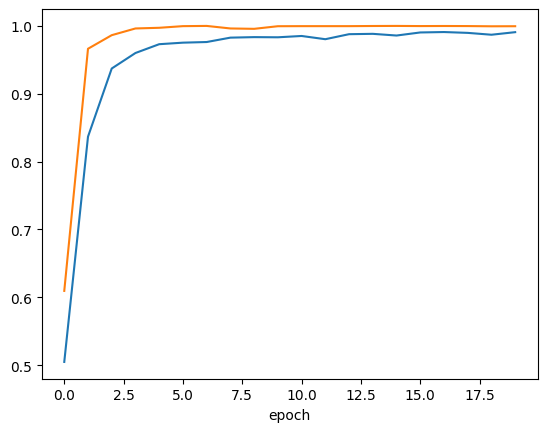

In [33]:
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

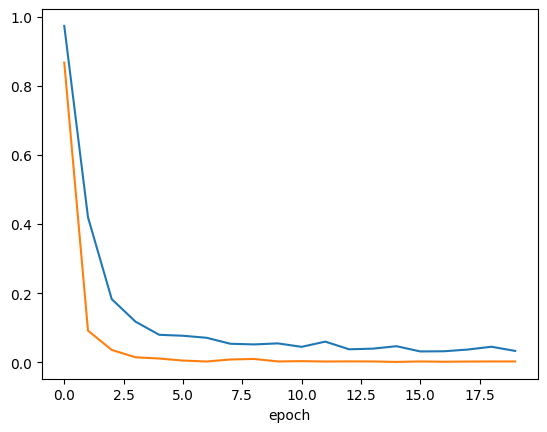

In [34]:
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.xlabel('epoch')

## 4.2 Model Evaluation

In [35]:
best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, label = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == label).sum().item()
    
    test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9998
